# Stacked Portfolio Optimizer (based on Vorobets, 2025)
For the strategic (low turnover layer) of the portfolio

In [18]:
#!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy seaborn yfinance

In [2]:
import numpy as np
import pandas as pd
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from copy import copy

In [4]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

selected_assets = [
    'NVDA', 'LLY', 'GS', 'DECK', 'COST', 'CAT', 
    'BTU', 'SHW', 'NRG', 'NFLX', 'CBRE', 'GC=F'
]
existing_assets = [c for c in selected_assets if c in data.columns]
data = data[existing_assets]

print(f"Assets found: {len(existing_assets)} / {len(selected_assets)}")
print(f"Observations: {len(data)} ({np.round(len(data)/252, 2)} years)")

data = data[data > 0]
data_clean = data.dropna(axis=0, how='any')
print(f"After cleaning: {len(data_clean)} obs")
print(f"Date range: {data_clean.index[0].date()} → {data_clean.index[-1].date()}")

pnl = np.diff(np.log(data_clean.values), axis=0)
pnl = pd.DataFrame(pnl, index=data_clean.index[1:], columns=data_clean.columns)

print(f"Returns: {pnl.shape[0]} days × {pnl.shape[1]} assets")

prior_stats = ft.simulation_moments(pnl)
np.round(prior_stats, 3)

Assets found: 12 / 12
Observations: 2471 (9.81 years)
After cleaning: 2471 obs
Date range: 2016-01-04 → 2025-11-11
Returns: 2470 days × 12 assets


,Mean,Volatility,Skewness,Kurtosis
NVDA,0.002,0.031,0.083,9.574
LLY,0.001,0.018,0.358,14.261
GS,0.001,0.018,-0.172,10.177
DECK,0.001,0.027,-0.606,14.204
COST,0.001,0.014,-0.525,11.839
CAT,0.001,0.019,-0.247,7.875
BTU,0.001,0.073,17.861,644.789
SHW,0.001,0.017,-0.713,18.313
NRG,0.001,0.025,0.167,16.473
NFLX,0.001,0.027,-1.798,35.876


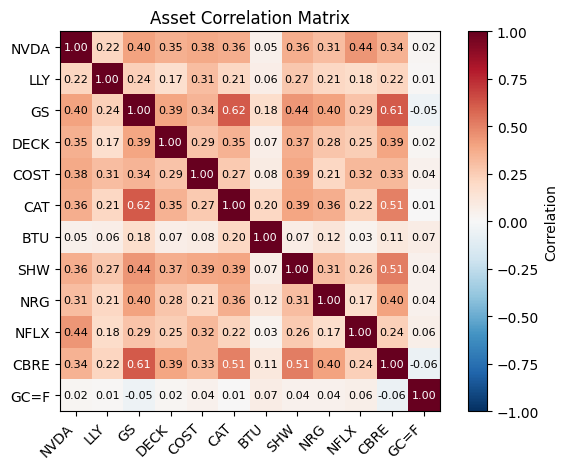

In [6]:
corr_matrix = pnl.corr()

plt.figure()
im = plt.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im, label='Correlation')

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        val = corr_matrix.iloc[i, j]
        color = 'white' if abs(val) > 0.5 else 'black'
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=8, color=color)

plt.title('Asset Correlation Matrix')
plt.tight_layout()
plt.show()

In [7]:
covariance_matrix = ft.covariance_matrix(pnl).values
means = prior_stats['Mean'].values

In [8]:
S, I = pnl.shape
R = pnl.values

# Long-only: weights >= 0
# Upper bound: weights <= 0.25 
G = np.vstack((np.eye(I), -np.eye(I)))
h = np.hstack((0.25 * np.ones(I), np.zeros(I)))

alpha = 0.9
cvar_opt = ft.MeanCVaR(R, G, h, alpha=alpha)

In [9]:
B = 1000  
P = 9   
pf_index = 4
N = 100  
np.random.seed(3)
return_sim = np.random.multivariate_normal(means, covariance_matrix, (N, B))

In [10]:
frontier = cvar_opt.efficient_frontier(P)
frontier_results = np.full((P, 2), np.nan)
means_full = prior_stats['Mean'].values  
frontier_results[:, 0] = means_full @ frontier
frontier_results[:, 1] = ft.portfolio_cvar(frontier, R)

In [11]:
p = np.ones((S, 1)) / S
frontier_mean = np.full((I, P, B), np.nan)
mean_results = np.full((P, 2, B), np.nan)

for b in range(B):
    if (b + 1) % 100 == 0:
        print(f"Progress: {b+1}/{B}")
    
    means_uncertainty = np.mean(return_sim[:, b, :], axis=0)
    q = ft.entropy_pooling(p, A=R.T, b=means_uncertainty[:, np.newaxis])
    
    R_weighted = R * q * S 
    
    cvar_opt_b = ft.MeanCVaR(R_weighted, G, h, alpha=alpha)
    
    frontier_mean[:, :, b] = cvar_opt_b.efficient_frontier(P)
    mean_results[:, 0, b] = means_full @ frontier_mean[:, :, b]
    mean_results[:, 1, b] = ft.portfolio_cvar(frontier_mean[:, :, b], R)

Progress: 100/1000
Progress: 200/1000
Progress: 300/1000
Progress: 400/1000
Progress: 500/1000
Progress: 600/1000
Progress: 700/1000
Progress: 800/1000
Progress: 900/1000
Progress: 1000/1000


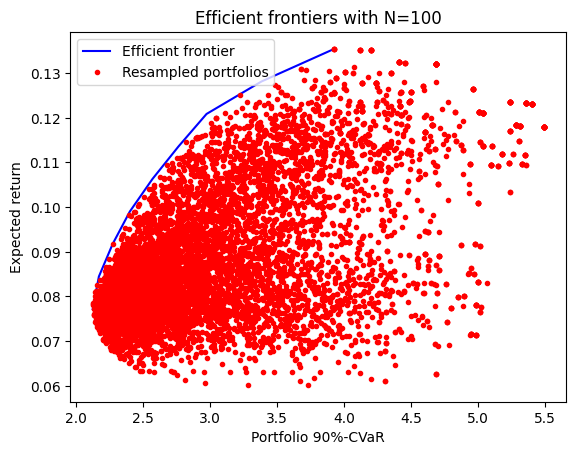

In [12]:
plt.plot(100 * frontier_results[:, 1], 100 * frontier_results[:, 0], 'b-')
plt.plot(100 * mean_results[:, 1, :], 100 * mean_results[:, 0, :], 'r.')
plt.legend(['Efficient frontier', 'Resampled portfolios'])
plt.title(f'Efficient frontiers with N={N}')
plt.ylabel('Expected return')
plt.xlabel('Portfolio 90%-CVaR')
plt.show()

In [13]:
def exposure_stacking(L, frontier, num_samples):
    """Computes the L-fold Exposure Stacking.

    Partitions the first num_samples samples from the frontier into L sets 
    of equal size and computes the L-fold Exposure Stacking.

    Args:
        L: Number of partition sets.
        frontier: Resampled exposures frontier with shape (I, P, B).
        num_samples: Number of samples to include.

    Returns:
        Exposure Stacking portfolio.    
    """
    partition_size = num_samples // L  
    M = frontier[:, pf_index, :num_samples].T
    P = np.zeros((num_samples, num_samples))
    q = np.zeros((num_samples, 1))
    for l in range(L):
        K_l = np.arange(l * partition_size, (l + 1) * partition_size)
        M_l = copy(M)
        M_l[K_l, :] = 0
        P = P + M_l @ M_l.T
        sum_exposures_K_l = np.sum(frontier[:, pf_index, K_l], axis=1)
        q = q + (M_l @ sum_exposures_K_l)[:, np.newaxis]
    P = matrix(2 * partition_size * P)
    q = matrix(-2 * q)

    A = matrix(np.ones((1, num_samples)))
    b = matrix(np.array([[1.]]))

    G = matrix(-np.identity(num_samples))
    h = matrix(np.zeros((num_samples, 1)))
    sol = solvers.qp(P, q, G, h, A, b)
    w = sol['x']
    exposure = np.squeeze(M.T @ w)
    return exposure

In [14]:
re_pf = np.mean(frontier_mean[:, pf_index, :], axis=1)
exposure_20 = exposure_stacking(20, frontier_mean, B)

In [15]:
exposure_20_ft = ft.exposure_stacking(20, frontier_mean[:, pf_index, :])
print(exposure_20_ft - exposure_20)

[-2.79981471e-08  2.60938407e-09  4.19002133e-08 -1.95371552e-08
  1.95515276e-08  4.38310774e-09 -5.13338103e-08  2.40961212e-08
  4.08095725e-08 -2.39380453e-08  6.90788624e-09 -1.74506543e-08]


In [16]:
exposures_for_display = np.round(np.vstack((re_pf, exposure_20, frontier[:, pf_index])) * 100, 2).T
pd.DataFrame(
    exposures_for_display,
    index=prior_stats.index,  
    columns=['Resampled', '20-fold', 'Frontier portfolio'])

,Resampled,20-fold,Frontier portfolio
NVDA,4.77,4.59,15.51
LLY,12.99,13.24,24.61
GS,4.90,4.72,0.00
DECK,5.52,5.37,0.00
COST,13.05,13.29,18.47
CAT,7.88,7.86,7.75
BTU,3.04,2.81,0.00
SHW,8.72,8.75,0.00
NRG,6.32,6.18,8.66
NFLX,6.33,6.24,0.00


In [17]:
w_resampled = re_pf
w_20fold = exposure_20
w_frontier = frontier[:, pf_index]

ret_resampled = means_full @ w_resampled
ret_20fold = means_full @ w_20fold
ret_frontier = means_full @ w_frontier

vol_resampled = np.sqrt(w_resampled @ covariance_matrix @ w_resampled)
vol_20fold = np.sqrt(w_20fold @ covariance_matrix @ w_20fold)
vol_frontier = np.sqrt(w_frontier @ covariance_matrix @ w_frontier)

cvar_resampled = ft.portfolio_cvar(w_resampled[:, np.newaxis], R)
cvar_20fold = ft.portfolio_cvar(w_20fold[:, np.newaxis], R)
cvar_frontier = ft.portfolio_cvar(w_frontier[:, np.newaxis], R)

performance = pd.DataFrame({
    'Resampled': [ret_resampled * 100, vol_resampled * 100, cvar_resampled * 100],
    '20-fold': [ret_20fold * 100, vol_20fold * 100, cvar_20fold * 100],
    'Frontier': [ret_frontier * 100, vol_frontier * 100, cvar_frontier * 100]
}, index=['Expected Return (%)', 'Volatility (%)', f'CVaR {int(alpha*100)}% (%)'])

np.round(performance, 4)

,Resampled,20-fold,Frontier
Expected Return (%),0.0860,0.0857,0.1063
Volatility (%),1.0373,1.0242,1.0821
CVaR 90% (%),2.4836,2.4519,2.5696
